In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [5]:
cfg = {}
cfg['img_dir'] = '/dgx/shared/momo/Data/MVTEc/bottle/train/good'
cfg['batch_size'] = 1
cfg['epochs'] = 1000
cfg['device'] = 'cuda:0'

<br>

## Define Teacher Network

In [6]:
pretrained_vgg = models.vgg19(pretrained=True)
teacher = pretrained_vgg.features[:36]
teacher = teacher.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', pretrained_vgg.features)
print('\n Teacher network \n', teacher)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Define Student Network

In [7]:
vgg = models.vgg19(pretrained=False)
student = vgg.features[:36]
student = student.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', vgg.features)
print('\n Student network \n', student)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Prepare Dataset

In [8]:
import cv2
import albumentations as albu

from pathlib import Path
from torch.utils.data import Dataset


class MVTecDataset(Dataset):
    
    def __init__(self,
                 img_dir: Path,
                 augmentations: albu.Compose = None,
                 preprocessing: albu.Compose = None) -> None:
        
        self.img_paths = [p for p in img_dir.glob('*.png')]
        self.augmentations = augmentations
        self.preprocessing = preprocessing

        
    def __getitem__(self, 
                    idx: int):
            
            # The original image from the dataset has RGB channels, but flipped in the form of BGR. 
            # So, we use CV2 to revert back to the standard RGB.
            img_path = str(self.img_paths[idx])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.augmentations:
                sample = self.augmentations(image=img)
                img = sample['image']

            if self.preprocessing:
                sample = self.preprocessing(image=img)
                img= sample['image']

            return img
        
        
    def __len__(self) -> int:
        
        return len(self.img_paths)

In [9]:
from albumentations.pytorch import ToTensorV2

train_augs = [albu.HorizontalFlip(p=0.5),
              albu.RandomCrop(height=128, width=128, always_apply=True, p=1)]
train_augs = albu.Compose(train_augs)    

preprocessing = [albu.Normalize(always_apply=True, p=1),
                 ToTensorV2()]
preprocessing = albu.Compose(preprocessing)

In [10]:
mvtec = MVTecDataset(img_dir=Path(cfg['img_dir']),
                     augmentations=train_augs,
                     preprocessing=preprocessing)

train_loader = DataLoader(dataset=mvtec,
                          batch_size=cfg['batch_size'],
                          shuffle=True)

<br>

## Train Student Network

In [11]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [12]:
teacher.eval()

for epoch in range(cfg['epochs']):
    for i, img in enumerate(train_loader):
         
        img = img.to(cfg['device'])
        with torch.no_grad():
            surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        loss.backward()
        optimizer.step()

    print(f'epoch: {epoch}')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

<br>

## Compute Anomaly Map

In [13]:
from albumentations.pytorch import ToTensorV2

preprocessing = [albu.Normalize(always_apply=True, p=1),
                 ToTensorV2()]
preprocessing = albu.Compose(preprocessing)

In [35]:
img_path = '/dgx/shared/momo/Data/MVTEc/bottle/test/broken_small/000.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [37]:
anomaly_map = np.zeros((900, 900))

teacher.eval()
student.eval()
for i in range(64, 900-64):
    for j in range(64, 900-64):
        patch = img[i-64:i+64, j-64:j+64]
        sample = preprocessing(image=patch)
        patch = sample['image']
        patch = patch.unsqueeze(0)
        patch = patch.to(cfg['device'])
        
        surrogate_label = teacher(patch)
        pred = student(patch)
        loss = criterion(pred, surrogate_label)
        anomaly_map[i, j] = loss.item()
    print(i)

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322


In [42]:
img = cv2.imread('/dgx/shared/momo/Data/MVTEc/bottle/test/broken_small/000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt = cv2.imread('/dgx/shared/momo/Data/MVTEc/bottle/ground_truth/broken_small/000_mask.png')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

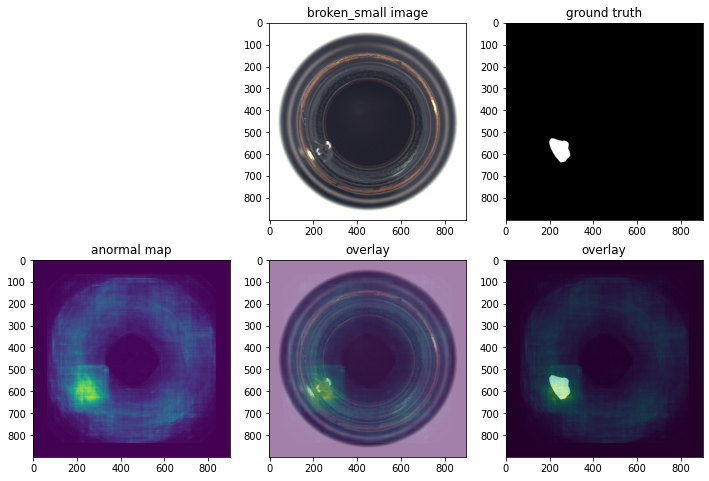

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(232)
plt.imshow(img)
plt.title('broken_small image')

plt.subplot(233)
plt.imshow(gt)
plt.title('ground truth')

plt.subplot(234)
plt.imshow(anomaly_map)
plt.title('anomal map')

plt.subplot(235)
plt.imshow(img)
plt.imshow(anomaly_map, alpha=0.5)
plt.title('overlay')

plt.subplot(236)
plt.imshow(anomaly_map)
plt.imshow(gt, alpha=0.5)
plt.title('overlay')

plt.show()